## LOAD LIBRARIES

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import os
import anndata as ad

In [2]:
input_path = '/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95'

files = os.listdir(input_path)
print(files)

for file in files:
    output_path = os.path.join(input_path, file, file, "outs")
    print(output_path)

['multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3', 'multiome95_VE-PC_Guttube_DE_IGO_17225_2', 'multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1']
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/outs
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_Guttube_DE_IGO_17225_2/multiome95_VE-PC_Guttube_DE_IGO_17225_2/outs
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/outs


### STRAIGHT TO R AND SOUPX

In [3]:
## first thing before importing rpy2 is to set R_HOME
os.environ["R_HOME"] = "/home/schroel1/miniconda3/envs/workshop_sail/lib/R"

import rpy2

%load_ext rpy2.ipython

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [4]:
%%R 
library('SoupX')



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading raw count data
10X data contains more than one type and is being returned as a list containing matrices of each type.
Loading cell-only count data
10X data contains more than one type and is being returned as a list containing matrices of each type.
Loading extra analysis data where available
70 genes passed tf-idf cut-off and 2 soup quantile filter.  Taking the top 2.
Using 4 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 8 clusters to 2370 cells.
Loading raw count data
10X data contains more than one type and is being returned as a list containing matrices of each type.
Loading cell-only count data
10X data contains more than one type and is being returned as a list containing matrices of each type.
Loading extra analysis data where available
96 genes passed tf-idf cut-off and 11 soup quantile filter.  Taking the top 11.
Using 30 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 8 clusters to 2587 cells.
Loading

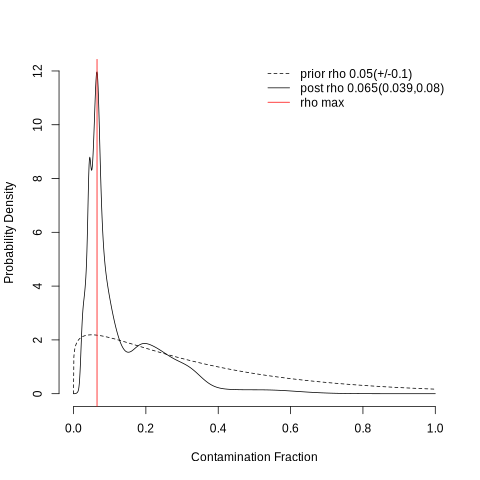

In [7]:
%%R -o out_ve1 -o out_ve2 -o out_de
library('SoupX')

sc_ve1 = load10X('/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/outs')
#sc_ve1 = setContaminationFraction(sc_ve1, 0.3)
sc_ve1 = autoEstCont(sc_ve1)
out_ve1 = adjustCounts(sc_ve1)

sc_ve2 = load10X('/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/outs')
#sc_ve2 = setContaminationFraction(sc_ve2, 0.3)
sc_ve2 = autoEstCont(sc_ve2)
out_ve2 = adjustCounts(sc_ve2)

sc_de = load10X('/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_Guttube_DE_IGO_17225_2/multiome95_VE-PC_Guttube_DE_IGO_17225_2/outs')
#sc_de = setContaminationFraction(sc_de, 0.3)
sc_de = autoEstCont(sc_de)
out_de = adjustCounts(sc_de)


In [8]:
out_ve1

<rpy2.robjects.methods.RS4 object at 0x2b958b078480> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [25]:
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro

# Activate conversion
pandas2ri.activate()


def r_dgCMatrix_to_scipy(r_matrix):
    i = np.array(r_matrix.do_slot('i'))
    p = np.array(r_matrix.do_slot('p'))
    x = np.array(r_matrix.do_slot('x'))
    dims = tuple(r_matrix.do_slot('Dim'))
    return scipy.sparse.csc_matrix((x, i, p), shape=dims)




In [26]:
# Convert to sparse matrix
X_ve1 = r_dgCMatrix_to_scipy(out_ve1)
# Get gene names and barcodes
genes_ve1 = list(r['rownames'](out_ve1))
barcodes_ve1 = list(r['colnames'](out_ve1))
X_ve1 = X_ve1.T  # This is essential
# Create AnnData
adata_ve1 = ad.AnnData(X=X_ve1)
adata_ve1.obs_names = barcodes_ve1  # cells
adata_ve1.var_names = genes_ve1  # genes
# Optional: ensure uniqueness
adata_ve1.obs_names_make_unique()
adata_ve1.var_names_make_unique()


# Convert to sparse matrix
X_ve2 = r_dgCMatrix_to_scipy(out_ve2)
# Get gene names and barcodes
genes_ve2 = list(r['rownames'](out_ve2))
barcodes_ve2 = list(r['colnames'](out_ve2))
X_ve2 = X_ve2.T  # This is essential
# Create AnnData
adata_ve2 = ad.AnnData(X=X_ve2)
adata_ve2.obs_names = barcodes_ve2  # cells
adata_ve2.var_names = genes_ve2  # genes
# Optional: ensure uniqueness
adata_ve2.obs_names_make_unique()
adata_ve2.var_names_make_unique()


# Convert to sparse matrix
X_de = r_dgCMatrix_to_scipy(out_de)
# Get gene names and barcodes
genes_de = list(r['rownames'](out_de))
barcodes_de = list(r['colnames'](out_de))
X_de = X_de.T  # This is essential
# Create AnnData
adata_de = ad.AnnData(X=X_de)
adata_de.obs_names = barcodes_de  # cells
adata_de.var_names = genes_de  # genes
# Optional: ensure uniqueness
adata_de.obs_names_make_unique()
adata_de.var_names_make_unique()

## SAVE OUTPUT

In [28]:
input_path = '/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95'


files = os.listdir(input_path)
print(files)

for file in files:
    output_path = os.path.join(input_path, file, file, "outs/soupx")
    print(output_path)
    os.makedirs(output_path, exist_ok = True)

['multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3', 'multiome95_VE-PC_Guttube_DE_IGO_17225_2', 'multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1']
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/outs/soupx
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_Guttube_DE_IGO_17225_2/multiome95_VE-PC_Guttube_DE_IGO_17225_2/outs/soupx
/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/outs/soupx


In [29]:
data_path = "/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/multiome95_VE-PC_wholeEmbryo_VE_1_IGO_17225_1/outs/soupx"
file_path = os.path.join(data_path, 'adata_soupx.h5ad')
adata_ve1.write_h5ad(file_path)

data_path = "/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/multiome95_VE-PC_E95_wholeEmbryo_VE_2_IGO_17225_3/outs/soupx"
file_path = os.path.join(data_path, 'adata_soupx.h5ad')
adata_ve2.write_h5ad(file_path)

data_path = "/data/hadjantalab/lucas/sonja_project/preprocessing/mapping/multiome95/multiome95_VE-PC_Guttube_DE_IGO_17225_2/multiome95_VE-PC_Guttube_DE_IGO_17225_2/outs/soupx"
file_path = os.path.join(data_path, 'adata_soupx.h5ad')
adata_de.write_h5ad(file_path)
